In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Current directory: /content/drive/MyDrive/CNET-Iteration-2
 All imports successful!

LOADING PREPROCESSED DATA
Validation data shape: (157253, 10, 79)
Validation labels shape: (157253,)

Class distribution:
  Normal (0): 20519
  Attack (1): 136734

LOADING LSTM AUTOENCODER
✅ Model loaded from results/models/lstm_autoencoder_final.keras
 LSTM Autoencoder loaded successfully!

LOADING ONE-CLASS SVM
✅ OC-SVM loaded from results/models/oc_svm.pkl
 OC-SVM loaded successfully!

EXTRACTING LATENT FEATURES
Latent features shape: (157253, 32)

MAKING PREDICTIONS
Predictions shape: (157253,)
Unique predictions: [0 1]

EVALUATION METRICS

Accuracy:  0.8897 (88.97%)
Precision: 0.9830 (98.30%)
Recall:    0.8885 (88.85%)
F1-Score:  0.9334 (93.34%)

False Positive Rate: 0.1023 (10.23%)
False Negative Rate: 0.1115 (11.15%)

------------------------------------------------------------
CONFUSION MATRIX
------------------------------------------------------------
True Negatives (TN):  18419
False Positiv

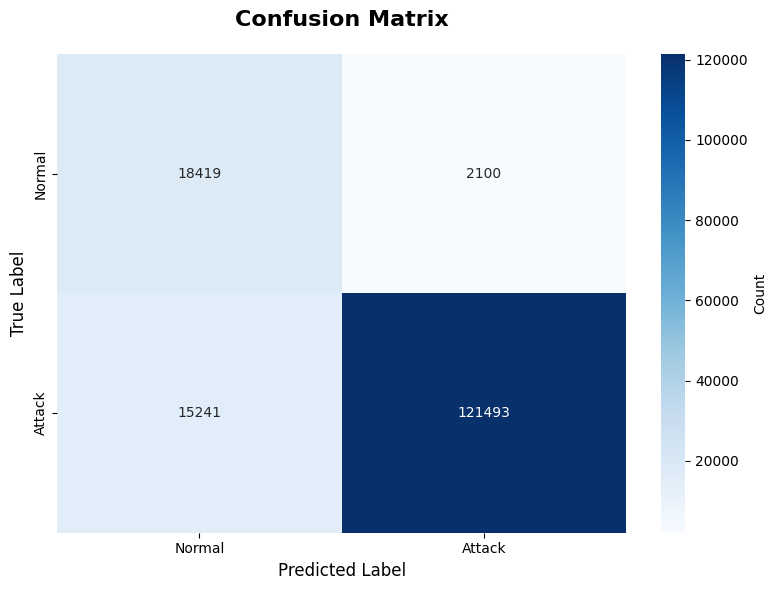

 Confusion matrix saved!

COMPUTING RECONSTRUCTION ERRORS
Reconstruction errors shape: (157253,)
Mean reconstruction error: 0.015392
Std reconstruction error: 0.009095

Normal traffic - Mean error: 0.012577
Attack traffic - Mean error: 0.015814

PLOTTING RECONSTRUCTION ERROR DISTRIBUTION


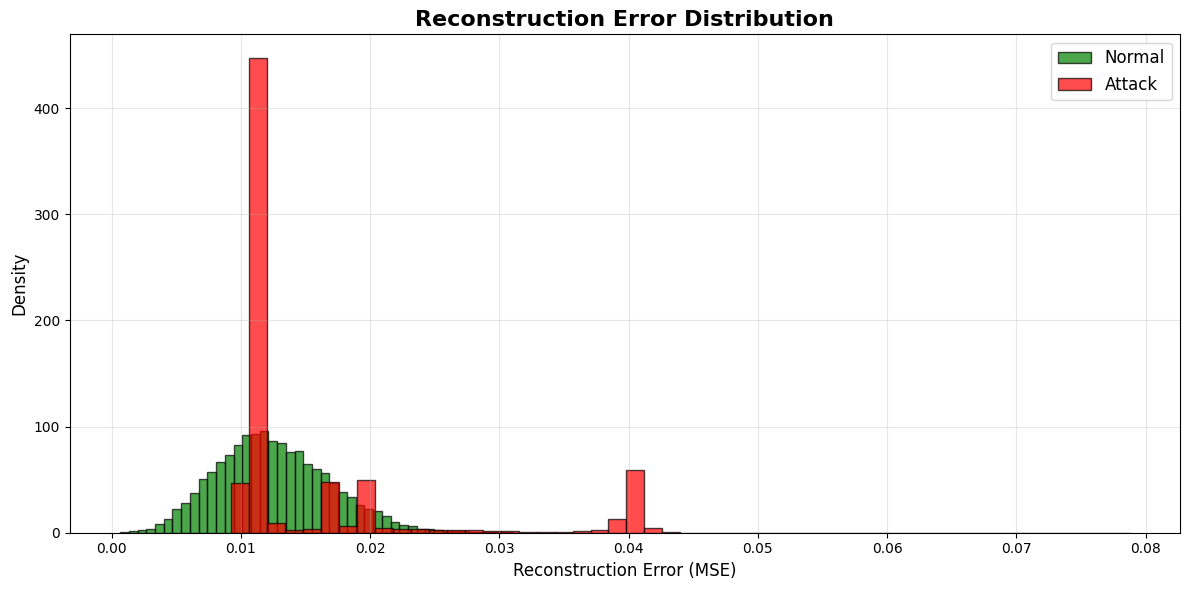

 Reconstruction error distribution saved!

PLOTTING ROC CURVE


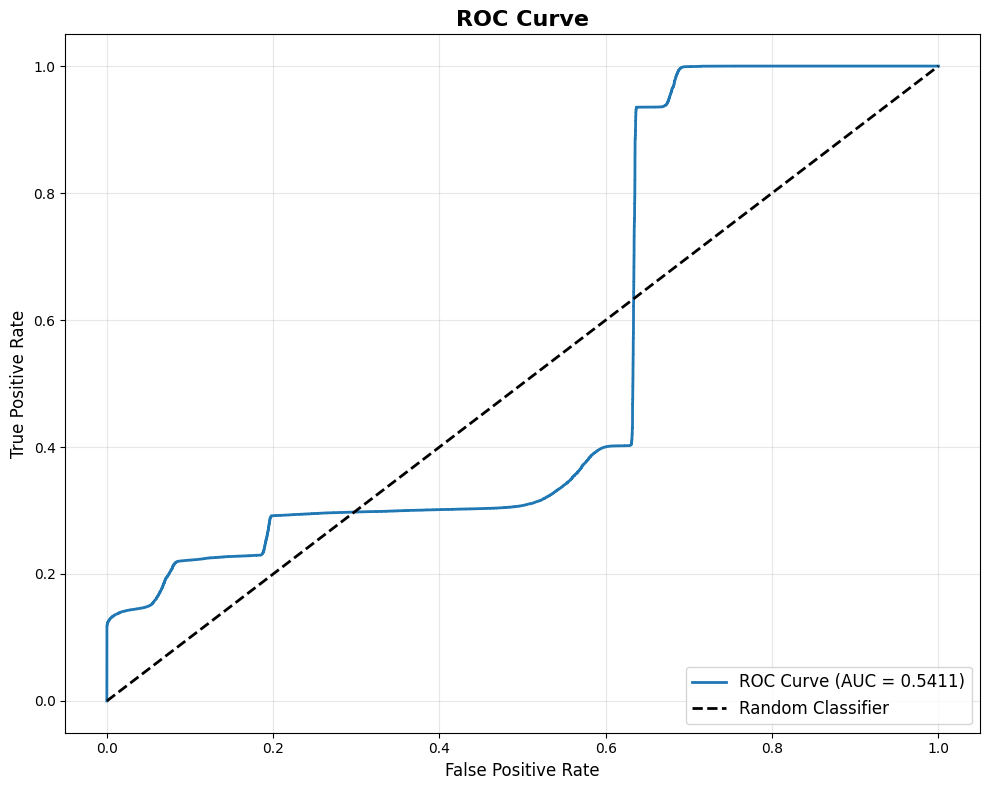

 ROC curve saved! AUC = 0.5411

COMPARISON WITH BASE PAPER

Metric          Original Paper  Our Result      Difference     
------------------------------------------------------------
Accuracy        0.8700          0.8897          0.0197         
Precision       0.8900          0.9830          0.0930         
Recall          0.9300          0.8885          -0.0415        
F1 Score        0.9100          0.9334          0.0234         
Fpr             0.0350          0.1023          0.0673         

PLOTTING COMPARISON


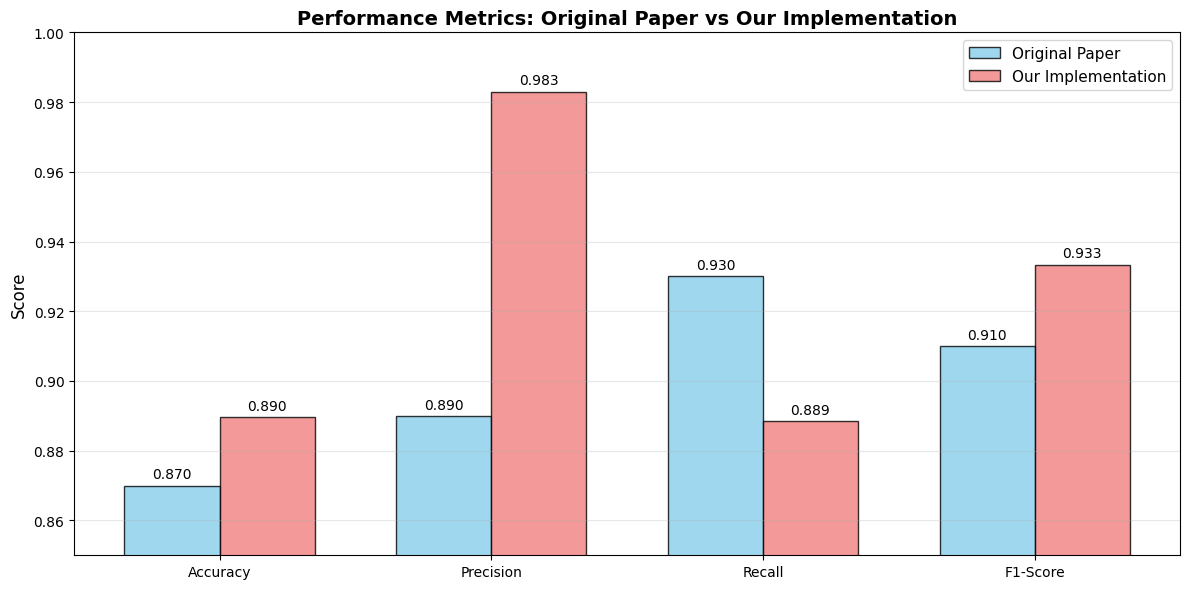

 Comparison plot saved!

SAVING METRICS
 Metrics saved to: results/metrics/evaluation_metrics.pkl

DETAILED CLASSIFICATION REPORT

               precision    recall  f1-score   support

      Normal     0.5472    0.8977    0.6799     20519
      Attack     0.9830    0.8885    0.9334    136734

    accuracy                         0.8897    157253
   macro avg     0.7651    0.8931    0.8067    157253
weighted avg     0.9261    0.8897    0.9003    157253


EVALUATION COMPLETE - SUMMARY

 All evaluation completed successfully!

Generated files:
  1. results/figures/confusion_matrix.png
  2. results/figures/reconstruction_error_distribution.png
  3. results/figures/roc_curve.png
  4. results/figures/metrics_comparison.png
  5. results/metrics/evaluation_metrics.pkl

KEY RESULTS
Accuracy:  0.8897 (88.97%)
Precision: 0.9830
Recall:    0.8885
F1-Score:  0.9334
ROC-AUC:   0.5411


In [5]:

import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Set paths
PROJECT_PATH = '/content/drive/MyDrive/CNET-Iteration-2'
sys.path.append(f'{PROJECT_PATH}/src')

# Change to project directory
os.chdir(PROJECT_PATH)


print(f"Current directory: {os.getcwd()}")

# === CELL 2: Import Libraries ===
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)
from model import LSTMAutoencoder, OneClassSVMClassifier

print(" All imports successful!")

# === CELL 3: Load Preprocessed Data ===
print("\n" + "="*60)
print("LOADING PREPROCESSED DATA")
print("="*60)

with open('data/processed/preprocessed_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_val = data['X_val']
y_val = data['y_val']

print(f"Validation data shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"\nClass distribution:")
print(f"  Normal (0): {np.sum(y_val == 0)}")
print(f"  Attack (1): {np.sum(y_val == 1)}")

# === CELL 4: Load LSTM Autoencoder ===
print("\n" + "="*60)
print("LOADING LSTM AUTOENCODER")
print("="*60)

lstm_ae = LSTMAutoencoder(
    sequence_length=X_val.shape[1],
    n_features=X_val.shape[2],
    latent_dim=32
)

try:
    lstm_ae.load_model('results/models/lstm_autoencoder_final.keras')
    print(" LSTM Autoencoder loaded successfully!")
except Exception as e:
    print(f" Error loading model: {e}")
    print("\n Please run the training notebook first!")
    raise

# === CELL 5: Load One-Class SVM ===
print("\n" + "="*60)
print("LOADING ONE-CLASS SVM")
print("="*60)

oc_svm = OneClassSVMClassifier()
try:
    oc_svm.load_model('results/models/oc_svm.pkl')
    print(" OC-SVM loaded successfully!")
except Exception as e:
    print(f" Error loading OC-SVM: {e}")
    print("\n Please run the training notebook first!")
    raise

# === CELL 6: Extract Latent Features ===
print("\n" + "="*60)
print("EXTRACTING LATENT FEATURES")
print("="*60)

latent_features_val = lstm_ae.extract_latent_features(X_val)
print(f"Latent features shape: {latent_features_val.shape}")

# === CELL 7: Make Predictions ===
print("\n" + "="*60)
print("MAKING PREDICTIONS")
print("="*60)

y_pred = oc_svm.predict(latent_features_val)

# Convert OC-SVM output (-1, 1) to (1, 0)
# OC-SVM: 1 = normal, -1 = anomaly
# Our labels: 0 = normal, 1 = attack
y_pred_binary = np.where(y_pred == 1, 0, 1)

print(f"Predictions shape: {y_pred_binary.shape}")
print(f"Unique predictions: {np.unique(y_pred_binary)}")

# === CELL 8: Calculate Metrics ===
print("\n" + "="*60)
print("EVALUATION METRICS")
print("="*60)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred_binary)
precision = precision_score(y_val, y_pred_binary, zero_division=0)
recall = recall_score(y_val, y_pred_binary, zero_division=0)
f1 = f1_score(y_val, y_pred_binary, zero_division=0)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_binary)
tn, fp, fn, tp = cm.ravel()

# Calculate rates
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

# Print metrics
print(f"\nAccuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print(f"\nFalse Positive Rate: {fpr:.4f} ({fpr*100:.2f}%)")
print(f"False Negative Rate: {fnr:.4f} ({fnr*100:.2f}%)")

print("\n" + "-"*60)
print("CONFUSION MATRIX")
print("-"*60)
print(f"True Negatives (TN):  {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP):  {tp}")

# === CELL 9: Plot Confusion Matrix ===
print("\n" + "="*60)
print("PLOTTING CONFUSION MATRIX")
print("="*60)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('results/figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Confusion matrix saved!")

# === CELL 10: Compute Reconstruction Errors ===
print("\n" + "="*60)
print("COMPUTING RECONSTRUCTION ERRORS")
print("="*60)

reconstruction_errors = lstm_ae.compute_reconstruction_error(X_val)
print(f"Reconstruction errors shape: {reconstruction_errors.shape}")
print(f"Mean reconstruction error: {np.mean(reconstruction_errors):.6f}")
print(f"Std reconstruction error: {np.std(reconstruction_errors):.6f}")

# Separate by class
normal_errors = reconstruction_errors[y_val == 0]
attack_errors = reconstruction_errors[y_val == 1]

print(f"\nNormal traffic - Mean error: {np.mean(normal_errors):.6f}")
print(f"Attack traffic - Mean error: {np.mean(attack_errors):.6f}")

# === CELL 11: Plot Reconstruction Error Distribution ===
print("\n" + "="*60)
print("PLOTTING RECONSTRUCTION ERROR DISTRIBUTION")
print("="*60)

plt.figure(figsize=(12, 6))

plt.hist(normal_errors, bins=50, alpha=0.7, label='Normal',
         color='green', density=True, edgecolor='black')
plt.hist(attack_errors, bins=50, alpha=0.7, label='Attack',
         color='red', density=True, edgecolor='black')

plt.xlabel('Reconstruction Error (MSE)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Reconstruction Error Distribution', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/figures/reconstruction_error_distribution.png',
            dpi=300, bbox_inches='tight')
plt.show()

print(" Reconstruction error distribution saved!")

# === CELL 12: Plot ROC Curve ===
print("\n" + "="*60)
print("PLOTTING ROC CURVE")
print("="*60)

# Calculate ROC curve
fpr_roc, tpr_roc, thresholds = roc_curve(y_val, reconstruction_errors)
roc_auc = roc_auc_score(y_val, reconstruction_errors)

plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, linewidth=2,
         label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/figures/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" ROC curve saved! AUC = {roc_auc:.4f}")

# === CELL 13: Comparison with Base Paper ===
print("\n" + "="*60)
print("COMPARISON WITH BASE PAPER")
print("="*60)

# Original paper results
original_results = {
    'accuracy': 0.87,
    'precision': 0.89,
    'recall': 0.93,
    'f1_score': 0.91,
    'fpr': 0.035
}

our_results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'fpr': fpr
}

print("\n{:<15} {:<15} {:<15} {:<15}".format(
    "Metric", "Original Paper", "Our Result", "Difference"
))
print("-" * 60)

for metric in ['accuracy', 'precision', 'recall', 'f1_score', 'fpr']:
    orig = original_results[metric]
    ours = our_results[metric]
    diff = ours - orig

    print("{:<15} {:<15.4f} {:<15.4f} {:<15.4f}".format(
        metric.replace('_', ' ').title(), orig, ours, diff
    ))

# === CELL 14: Plot Comparison ===
print("\n" + "="*60)
print("PLOTTING COMPARISON")
print("="*60)

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
original_values = [0.87, 0.89, 0.93, 0.91]
our_values = [accuracy, precision, recall, f1]

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, original_values, width,
               label='Original Paper', color='skyblue', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, our_values, width,
               label='Our Implementation', color='lightcoral', alpha=0.8, edgecolor='black')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Performance Metrics: Original Paper vs Our Implementation',
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.85, 1.0])

# Add value labels on bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.savefig('results/figures/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Comparison plot saved!")

# === CELL 15: Save All Metrics ===
print("\n" + "="*60)
print("SAVING METRICS")
print("="*60)

metrics_dict = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'true_negatives': int(tn),
    'false_positives': int(fp),
    'false_negatives': int(fn),
    'true_positives': int(tp),
    'false_positive_rate': fpr,
    'false_negative_rate': fnr,
    'roc_auc': roc_auc,
    'confusion_matrix': cm.tolist(),
    'reconstruction_errors': {
        'normal_mean': float(np.mean(normal_errors)),
        'attack_mean': float(np.mean(attack_errors)),
        'normal_std': float(np.std(normal_errors)),
        'attack_std': float(np.std(attack_errors))
    }
}

with open('results/metrics/evaluation_metrics.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f)

print(" Metrics saved to: results/metrics/evaluation_metrics.pkl")

# === CELL 16: Classification Report ===
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)

print("\n", classification_report(y_val, y_pred_binary,
                                  target_names=['Normal', 'Attack'],
                                  digits=4))

# === CELL 17: Final Summary ===
print("\n" + "="*60)
print("EVALUATION COMPLETE - SUMMARY")
print("="*60)

print("\n All evaluation completed successfully!")
print("\nGenerated files:")
print("  1. results/figures/confusion_matrix.png")
print("  2. results/figures/reconstruction_error_distribution.png")
print("  3. results/figures/roc_curve.png")
print("  4. results/figures/metrics_comparison.png")
print("  5. results/metrics/evaluation_metrics.pkl")

print("\n" + "="*60)
print("KEY RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print("="*60)
